# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [1]:
from __future__ import division
from IPython.display import clear_output
# imports to run OpenAI Gym in Jupyter
import gym
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure()
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# transforms the state into what the tpg agent can use.
# From 3D to 1D, taking only red data (from rgb array)
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0])
            
    return state2

In [2]:
env = gym.make('Assault-v0') # make the environment

In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [4]:
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent

## Example: Basic Generational Selection (with graphics)

KeyboardInterrupt: 

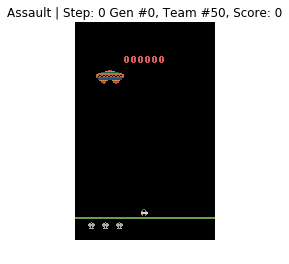

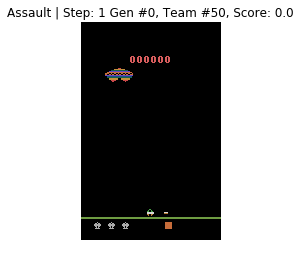

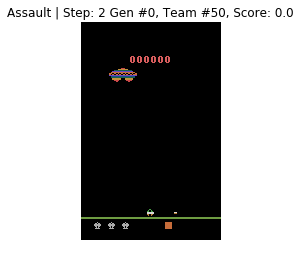

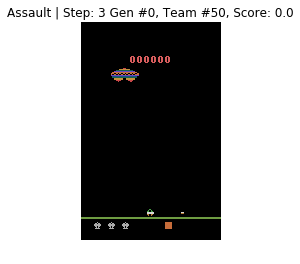

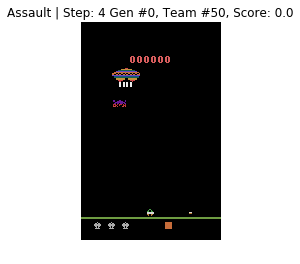

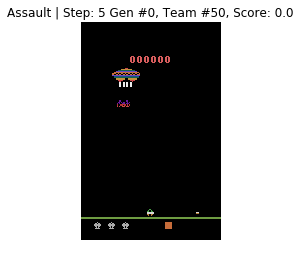

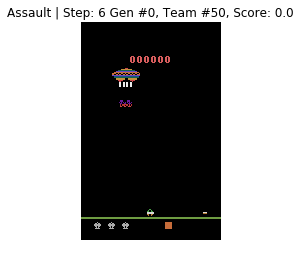

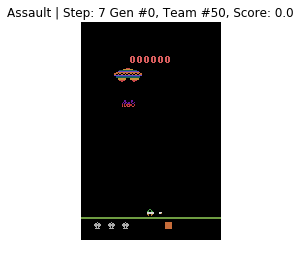

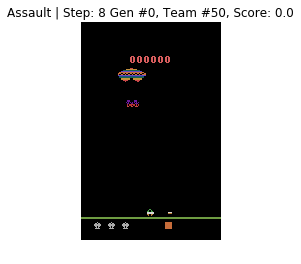

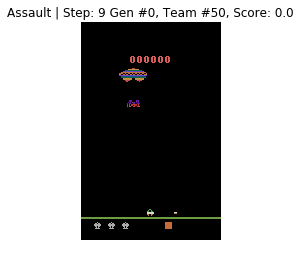

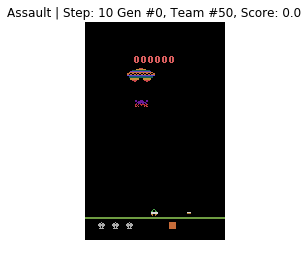

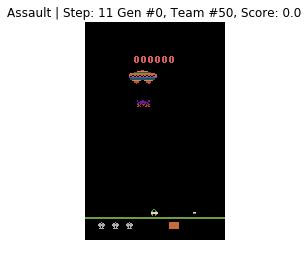

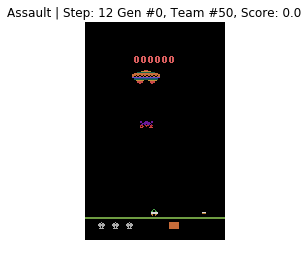

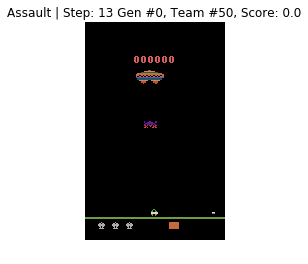

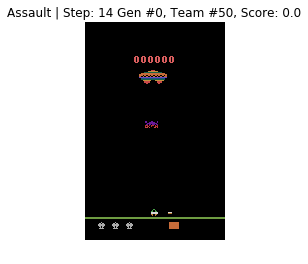

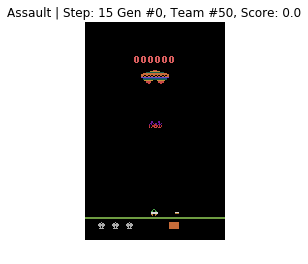

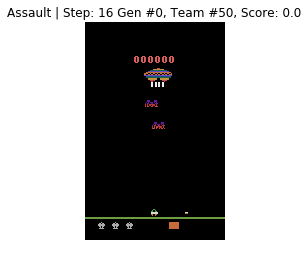

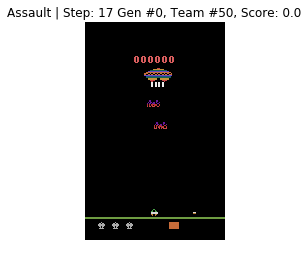

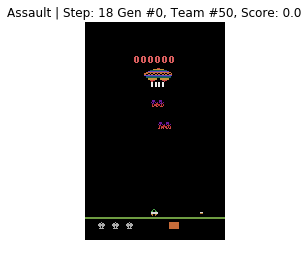

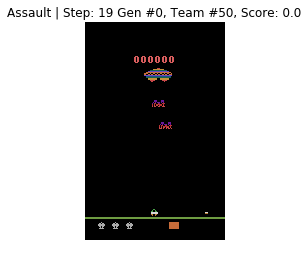

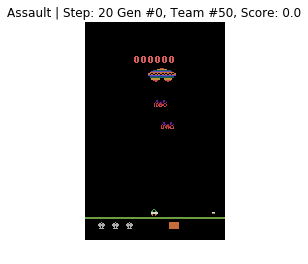

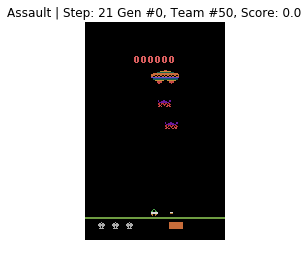

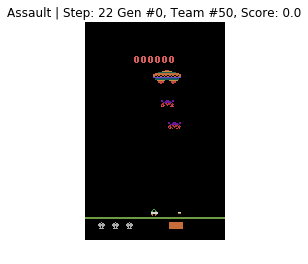

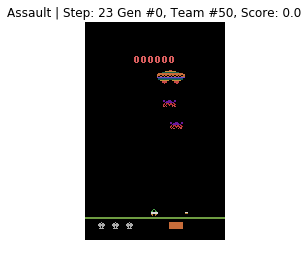

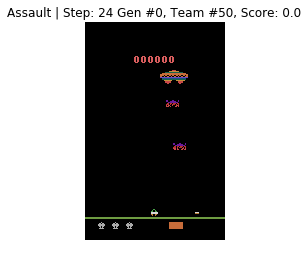

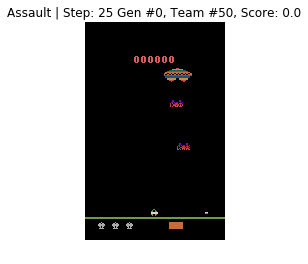

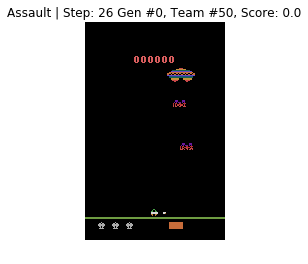

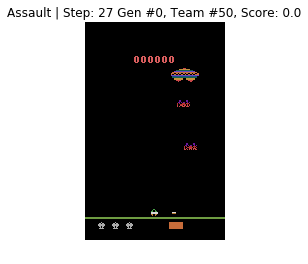

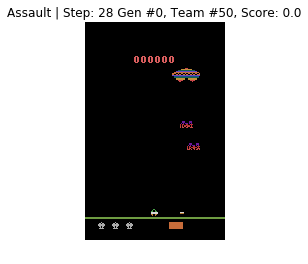

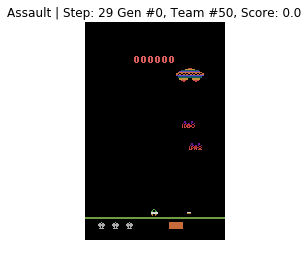

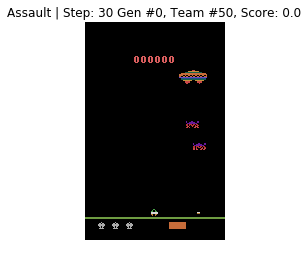

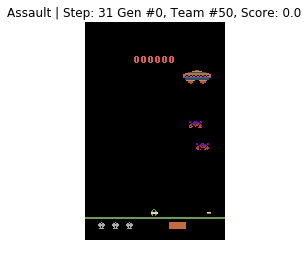

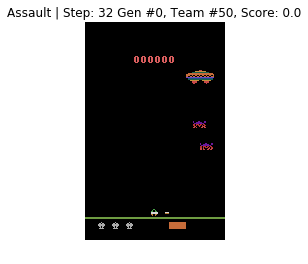

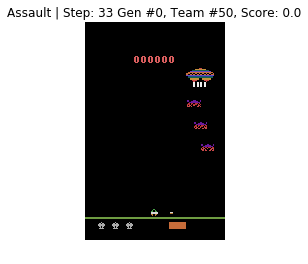

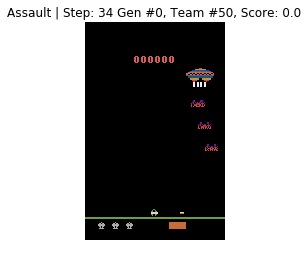

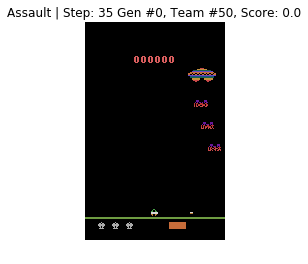

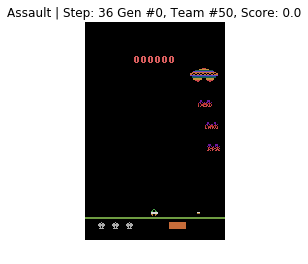

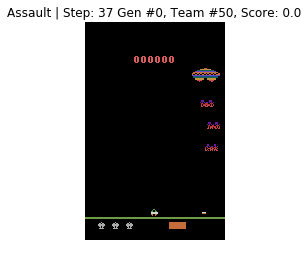

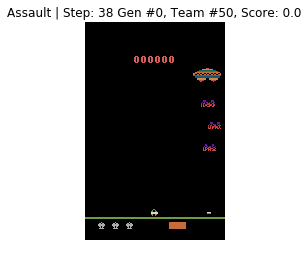

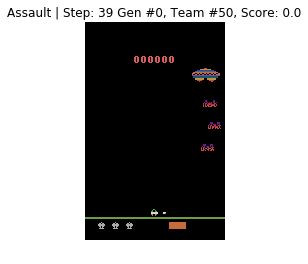

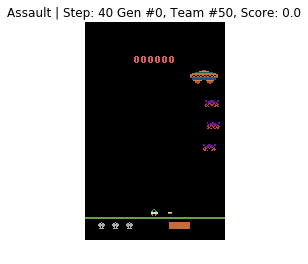

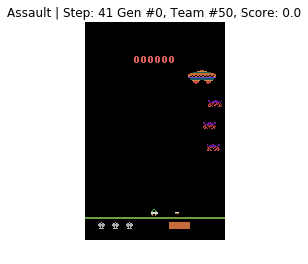

In [5]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7), teamPopSize=50)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(200): # run episodes that last 200 frames
                show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                           ', Team #' + str(teamNum) +
                           ', Score: ' + str(score)) # render env

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
#clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])

## Example: Generational Selection with Multiprocessing (no graphics)

This example is just to show a different way to run the API. It uses a different method to get the agents, doesn't use graphics, and uses multiprocessing. For a more in depth comparison of run performances with different configurations see {Section Name}.

In [7]:
# run agent in function to work with multiprocessing
def runAgent(agenteqsq):
    agent = agenteqsq[0] # get agent
    eq = agenteqsq[1] # get environment queue
    sq = agenteqsq[2] # get score queue
    
    # check if agent already has score
    if agent.taskDone():
        print('Agent #' + str(agent.getAgentNum()) + ' can skip.')
        sq.put((agent.getUid(), agent.getOutcomes()))
        return
        
    print('envs in queue:',eq.qsize())
    env = eq.get() # get an environment
    state = env.reset() # get initial state and prep environment
    score = 0
    for i in range(1000): # run episodes that last 200 frames
        act = agent.act(getState(state)) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state
            
    lock.acquire() # may not actually need, mp is weird in python
    agent.reward(score) # must reward agent
    lock.release()
    
    print('Agent #' + str(agent.getAgentNum()) + ' finished with score ' + str(score))
    sq.put((agent.getUid(), agent.getOutcomes())) # get outcomes with id
    eq.put(env) # put environment back

In [10]:
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSize=50)

processes = 6 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for each gen (min, max, avg)
    
    
for gen in range(10): # generation loop
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score

    # run generation
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getAllAgents(skipTasks=[])])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    
    # apply scores
    trainer.applyScores(scores)
    trainer.evolve(tasks=[]) # go into next gen

    # at end of generation, make summary of scores
    summaryScores.append((trainer.scoreStats['min'], 
                    trainer.scoreStats['max'],
                    trainer.scoreStats['average'])) # min, max, avg
    
    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(time.time() - tStart))
    print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Time Taken (Seconds): 586.3605582714081
Results: [(0.0, 483.0, 62.58), (0.0, 567.0, 112.875), (0.0, 483.0, 192.5), (0.0, 546.0, 301.59574468085106), (0.0, 546.0, 356.5531914893617), (0.0, 567.0, 364.6829268292683), (0.0, 567.0, 376.425), (0.0, 588.0, 407.7073170731707), (63.0, 609.0, 427.1707317073171), (0.0, 609.0, 427.875)]


## Tournament Selection

In [4]:
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSizeInit=360)

processes = 4 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for population
    
# tournament loop 
# 450 tournaments of size 8 approximately equals 10 generations
# *at pop size 360
for tourn in range(450): 
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score

    # run tournament
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getTournamentAgents()])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    
    # apply scores
    teams = trainer.applyScores(scores) # get teams from trainer
    trainer.evolve(tourneyTeams=teams,tasks=[]) # evolve tournament players
    
    # report score once equivalent to a generation
    if (tourn+1) % 45 == 0:
        scoreStats = trainer.generateScoreStats()

        # at end of generation, make summary of scores
        summaryScores.append((scoreStats['min'], 
                        scoreStats['max'],
                        scoreStats['average'])) # min, max, avg

        clear_output(wait=True)
        print('Time Taken (Seconds): ' + str(time.time() - tStart))
        print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Time Taken (Seconds): 45202.94136309624
Results: [(0, 16905.0, 50.91867469879518), (0, 31521.0, 99.43533123028391), (0, 47733.0, 157.01644736842104), (0, 59262.0, 196.2317880794702), (0, 63903.0, 215.16161616161617), (0, 66339.0, 230.34375), (0, 68754.0, 242.09154929577466), (0, 68460.0, 244.5), (0, 73290.0, 251.8556701030928), (0, 70371.0, 256.8284671532847)]


In [11]:
"""
test 1 
- pop size = 50,

"""
# run agent in function to work with multiprocessing
def runAgent(agenteqsq):
    agent = agenteqsq[0] # get agent
    eq = agenteqsq[1] # get environment queue
    sq = agenteqsq[2] # get score queue
    
    # check if agent already has score
    if agent.taskDone():
        print('Agent #' + str(agent.getAgentNum()) + ' can skip.')
        sq.put((agent.getUid(), agent.getOutcomes()))
        return
        
    print('envs in queue:',eq.qsize())
    env = eq.get() # get an environment
    state = env.reset() # get initial state and prep environment
    score = 0
    for i in range(1000): # run episodes that last 200 frames
        act = agent.act(getState(state)) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state
            
    lock.acquire() # may not actually need, mp is weird in python
    agent.reward(score) # must reward agent
    lock.release()
    
    print('Agent #' + str(agent.getAgentNum()) + ' finished with score ' + str(score))
    sq.put((agent.getUid(), agent.getOutcomes())) # get outcomes with id
    eq.put(env) # put environment back
    
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSize=50)

processes = 6 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for each gen (min, max, avg)
    
    
for gen in range(10): # generation loop
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score

    # run generation
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getAllAgents(skipTasks=[])])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    
    # apply scores
    trainer.applyScores(scores)
    trainer.evolve(tasks=[]) # go into next gen

    # at end of generation, make summary of scores
    summaryScores.append((trainer.scoreStats['min'], 
                    trainer.scoreStats['max'],
                    trainer.scoreStats['average'])) # min, max, avg
    
    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(time.time() - tStart))
    print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Time Taken (Seconds): 586.0285983085632
Results: [(0.0, 567.0, 62.16), (0.0, 567.0, 85.7872340425532), (0.0, 567.0, 172.1086956521739), (0.0, 567.0, 283.5), (0.0, 567.0, 292.0), (0.0, 609.0, 355.0), (0.0, 609.0, 384.63157894736844), (0.0, 630.0, 404.86046511627904), (0.0, 630.0, 434.5), (0.0, 630.0, 414.8780487804878)]


In [12]:
"""
test 2
- pop size = 50,

"""
# run agent in function to work with multiprocessing
def runAgent(agenteqsq):
    agent = agenteqsq[0] # get agent
    eq = agenteqsq[1] # get environment queue
    sq = agenteqsq[2] # get score queue
    
    # check if agent already has score
    if agent.taskDone():
        print('Agent #' + str(agent.getAgentNum()) + ' can skip.')
        sq.put((agent.getUid(), agent.getOutcomes()))
        return
        
    print('envs in queue:',eq.qsize())
    env = eq.get() # get an environment
    state = env.reset() # get initial state and prep environment
    score = 0
    for i in range(1000): # run episodes that last 200 frames
        act = agent.act(getState(state)) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state
            
    lock.acquire() # may not actually need, mp is weird in python
    agent.reward(score) # must reward agent
    lock.release()
    
    print('Agent #' + str(agent.getAgentNum()) + ' finished with score ' + str(score))
    sq.put((agent.getUid(), agent.getOutcomes())) # get outcomes with id
    eq.put(env) # put environment back
    
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSize=50)

processes = 6 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for each gen (min, max, avg)
    
    
for gen in range(10): # generation loop
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score

    # run generation
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getAllAgents(skipTasks=[])])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    
    # apply scores
    trainer.applyScores(scores)
    trainer.evolve(tasks=[]) # go into next gen

    # at end of generation, make summary of scores
    summaryScores.append((trainer.scoreStats['min'], 
                    trainer.scoreStats['max'],
                    trainer.scoreStats['average'])) # min, max, avg
    
    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(time.time() - tStart))
    print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Time Taken (Seconds): 612.8209958076477
Results: [(0.0, 504.0, 42.42), (0.0, 504.0, 54.51063829787234), (0.0, 504.0, 80.92682926829268), (0.0, 504.0, 116.45454545454545), (0.0, 504.0, 209.51162790697674), (0.0, 546.0, 253.02439024390245), (0.0, 504.0, 296.15384615384613), (0.0, 504.0, 329.7567567567568), (0.0, 525.0, 348.25), (0.0, 525.0, 332.5)]
